<h1 align="center"> Handwritten Simple Equation Solver </h1>

$by: Jeremiah\ Chinyelugo$

## Before we Begin:
If you like my work, please upvote because it will encourage me to keep on working on various machine learning projects that like this that pique my interest.

## Introduction
I recently started learning about Convolutional Neural Networks (CNN), various architectures, techniques used and available pretrained models. Having worked on projects like classification of `dogs_vs_cats`, `fashion_mnist` and `CIFAR_10`, i thought i would be interesting to apply the knowledge i have gained working on an idea i have had for a while now.

In this kernel, we are going to create a vanilla CNN model to see if we can accurately predict the numbers in a image and perform basic mathematical calculations based on our predictions.

## Main Objectives:
* Extracting digits using a proper Image Segmentation function
* Processing our inputs into the appropriate format reqiured for the model
* Train a CNN that can accurately predict segmented digits
* Create a function that can perform calculations based on model prediction
* Identify some limitations of our model
* How we can possibly improve our model

## Sections:

## References:
* Hands on Machine Learning with scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron
 
## Data:
* Main Dataset: [Kalikichandu - Classifying Handwritten math symbols-Fastai](https://www.kaggle.com/code/kalikichandu/classifying-handwritten-math-symbols-fastai/data)
* Handwritten images: [Jose Joy - Handwritten-Expression-Evaluation](https://github.com/JoseJoy249/Handwritten-Expression-Evaluation/tree/master/Equation%20data)

## The Dataset

The entire dataset contains over 375,000+ handwritten images of 82 maths symbols. However, for the purpose of this kernel, we will be limiting our use to just 15 of the available symbols.<br/>
Each image in the dataset consists of 45x45 pixels with 1 channel (Black/white), which we will be resizing later on in the notebook. The dataset has no labels, so we will be creating ours.

###### Importing the libraries

In [12]:
import sklearn
sklearn.__version__

'1.1.1'

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpig
import seaborn as sns
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow import keras
from functools import partial
import random

import warnings
warnings.filterwarnings('ignore')

Creating a list of math symbols we will extract from our root directory

In [5]:
equation_list = ["-","+","div","X","times","0","1","2","3","4","5","6","7","8","9"]

Extracting the images from their respective folders in the root directory and appending them to the `train` and `target` lists.

In [6]:
# Because we have no labels, we will be using the symbol name as a placeholder label for now

root = '.\data\extracted_images'
train = []
target = []

for dig in tqdm.tqdm(equation_list):
    dig = str(dig)
    for dirname, _, filenames in os.walk(os.path.join(root,dig)):
        for filename in filenames:
            filepath = os.path.join(dirname,filename)
            train.append(mpig.imread(filepath))
            target.append(dig)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [02:00<00:00,  8.04s/it]


In [7]:
print(f"Train set size: {len(train):,}")
print(f"Target set size: {len(target):,}")

Train set size: 184,079
Target set size: 184,079


In [8]:
# coverting both lists into an array, so it is easier to manipulate our data

train = np.array(train)
target = np.array(target)

We have no labels for our

In [6]:
# creating a dictionary so we can map our symbols to numbers, this allows us to train the data

map_dict = {}
for idx, dig in enumerate(equation_list):
    map_dict[idx] = dig

In [7]:
map_dict

{0: '-',
 1: '+',
 2: 'div',
 3: 'X',
 4: 'times',
 5: '0',
 6: '1',
 7: '2',
 8: '3',
 9: '4',
 10: '5',
 11: '6',
 12: '7',
 13: '8',
 14: '9'}

Now we have created our mapping dictionary above, we need to convert our labels (i.e symbols) to numbers. We can do this easily by replacing the labels with their respective dictionary key.

In [11]:
# creating a list of conditions and choices

conds = [target=='-',target=='+',target=='div',target=='X',target=='times',target=='0',target=='1',target=='2',target=='3',
         target=='4',target=='5',target=='6',target=='7',target=='8',target=='9']
choices = list(map_dict.keys())

In [12]:
# applying the conditions and choices

target = np.select(conds, choices)

In [13]:
# we can see we have successfully changed our labels to numbers

np.unique(target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

our train data contains pixel values ranging from 0~255, so we need to make our pixel values either 1 or 0.

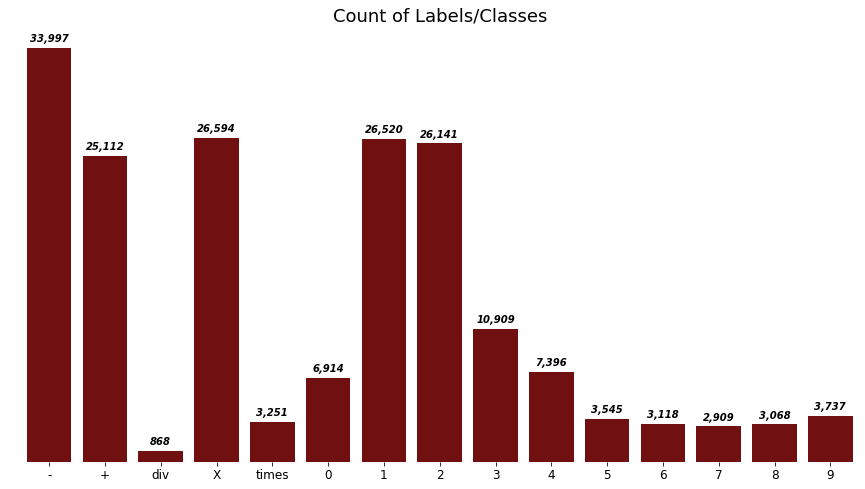

In [14]:
# visualizing the count of distinct labels we have

from collections import Counter
count = Counter(target)

plt.figure(figsize=(15,8))
g = sns.countplot(target, color='maroon')

for key in map_dict.keys():
    plt.annotate(f"{count[key]:,}", (key,count[key]+500), horizontalalignment='center', 
                 style='italic', weight='bold')

g.set_xticklabels(list(map_dict.values()), fontsize=12)
sns.despine(left=True, bottom=True)
plt.title("Count of Labels/Classes", fontsize=18)
plt.yticks([], [])
plt.ylabel(" ")
plt.show()

We can see that we have an unbalanced number of instances for ecah class and this can result in poor model performance on classes with small instances. To rectify this, we will use the ***Synthethic Minority Oversamoling Technique*** **(SMOTE)** later on in this kernel to address the imbalanced datasets by oversampling the minority classes.

In [29]:
# chaning pixel values

train = np.where(train==0, 1, 0)

In [30]:
# creating a function to quickly plot our image 

def plot_image(image):
    plt.imshow(image, cmap='gray')
    return plt.show()

1. need to resize images
2. split into train, valid, test - DONE
3. create a data pipeline, using tf.data
4. data augmentation using imageDataGenerator
5. create CNN model
6. train data
7. create processing function for new images
8. create sympy function for silving equation
9. create streamlit app
10. deploy

## Processing the data

In this part of our kernel, we will be processing our data to make it suitable for training. We need to do this because as we will see below, the images have been cropped so we won't get the best performance from our model because most of the images are indistinguishable from each other, even to humans.<br/> Before we pad our images, we need to first split our dataset into the train set, validation set and test set.

###### Splitting the dataset into train, valid and test set

In [42]:
X_train_full, X_test, y_train_full, y_test = train_test_split(train, target, random_state=42, test_size=.1,
                                             stratify=target)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42,
                                             stratify=y_train_full)

In [43]:
# converting them back to arrays

X_train = np.array(X_train)
X_valid = np.array(X_valid)
X_test = np.array(X_test)

### Padding

A common use case for padding arrays or tensors is adding zeros around the border of images to convert them to a shape that is amenable to the convolution operation without throwing away any pixel information

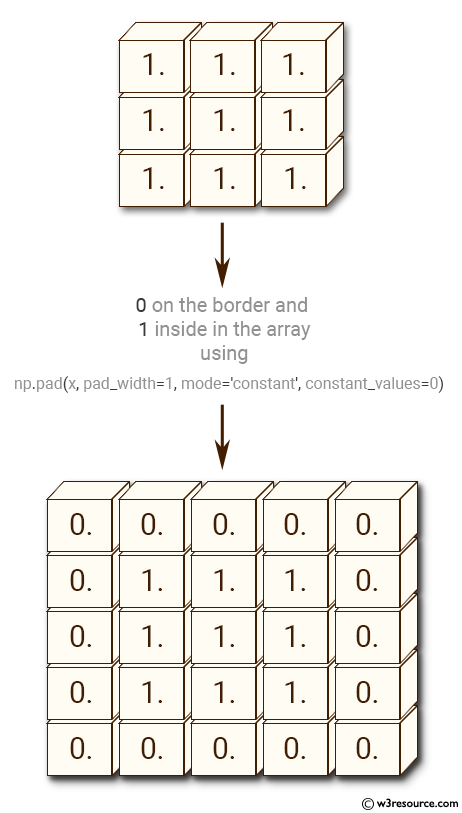

before we pad our images, let's plot some of them to get a visual representation of how they look.

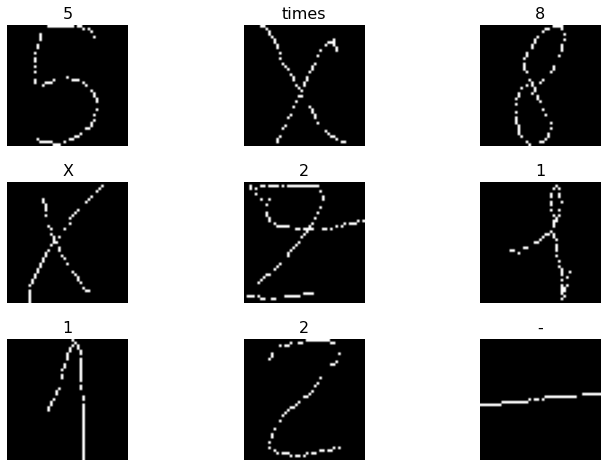

In [44]:
plt.figure(figsize=(12,8))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i*15_000], cmap='gray')
    plt.axis('off')
    plt.title(map_dict[y_train[i*15_000]], fontsize=16)
plt.subplots_adjust(hspace=.3)
plt.show()

we can see that our images have been cropped and if we proceed with using this in our model, we will get terrible results because the model won't be able to accuractely distinguish the difference bewtween some symbols.

Therefore, we have to perform some minor augmentation on our images. let's add some padding to the borders of our images and see how it looks

In [45]:
# creating the padding function

def pad_image(data):
    mylist = []
    for i in range(len(data)):
        mylist.append(np.pad(data[i], 5))
    return np.array(mylist)

In [46]:
X_train = pad_image(X_train)
X_valid = pad_image(X_valid)

In [47]:
X_test = pad_image(X_test)

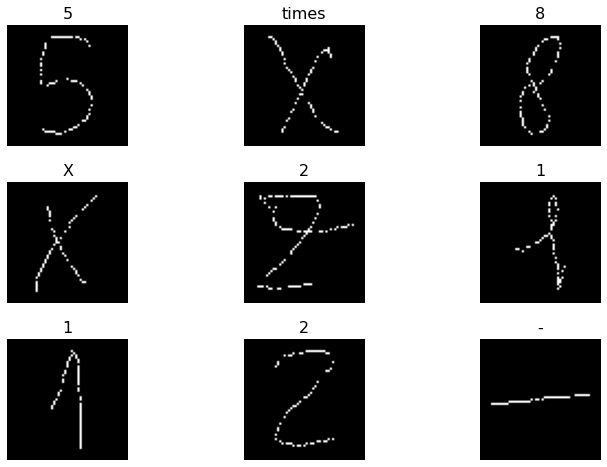

In [48]:
# plotting our padded images

plt.figure(figsize=(12,8))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i*15_000], cmap='gray')
    plt.axis('off')
    plt.title(map_dict[y_train[i*15_000]], fontsize=16)
plt.subplots_adjust(hspace=.3)
plt.show()

Much better!<br/>

Next, we will increase the number of instances in our train dataset by oversampling the minority classes like i discussed earlier.

In [50]:
# reshaping the train dataset to 2-dimensions

X_train = X_train.reshape(X_train.shape[0], 3025)

In [51]:
from sklearn.pipeline import Pipeline
over = SMOTE()

# applying the SMOTE

X_train, y_train = over.fit_resample(X_train, y_train)

In [54]:
# reshaping our train dataset to its previous dimension

X_train = X_train.reshape(X_train.shape[0], 55, 55)

In [55]:
# adding an extra dimension for channel to our data

X_train = X_train[:,:,:,np.newaxis]
X_valid = X_valid[:,:,:,np.newaxis]
X_test = X_test[:,:,:,np.newaxis]

## Model

In this section we will be creating a simple Convolutional Neural Network model with few hidden layers because our images have few lower level features (compared to an image of an animal).

Before we commence building our model, we will create a partial function which allows to fix certain arguments of the initial function so we can generate new functions. This way, we can call the same function while changing some arguments without having to type out the function everytime.

For this model, we will use two (2) MaxPooling layers with a pool size of 2, one (1) dense layer with 100 units and the relu activation. To introduce some regularization and reduce overfitting, we will use a dropout layer with a rate of `0.5` (i.e 50%).

***`N.B:` `If we had detailed images, we would need to increase the numbers of hidden layers in our model and maybe use a Residual Network to improve our model performance. There might be a trade off between model performance and computation speed.`***

In [58]:
keras.backend.clear_session()

In [59]:
# building the model

DefaultConv2D = partial(keras.layers.Conv2D,
                       kernel_size=3, activation='relu', padding='SAME')

model = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=7, input_shape=[55,55,1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(15, activation='softmax')
])

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 32)        1600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

 Next we need to compile the model, because our targets are mutually exclusive (i.e 0,1,2,3,...) we need to use `sparse_categorical_crossentropy` as our loss function. 
 
There are several callbacks we can use to perform actions at various stages in training. For this project, we will use an EarlyStoppingCallback so we can stop training the model when model performace doesn't increase after a specified number of epochs.

In [61]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
             metrics=['accuracy'])

# setting our callback
EarlyStopping_cb = keras.callbacks.EarlyStopping(patience=5)

# Training the model using 20 epochs
history = model.fit(X_train, y_train, epochs=20, 
                   validation_data=(X_valid, y_valid),
                   callbacks=[EarlyStopping_cb])

Epoch 1/20
10757/10757 [==============================] - 892s 83ms/step - loss: 0.2918 - accuracy: 0.9060 - val_loss: 0.0764 - val_accuracy: 0.9666
Epoch 2/20
10757/10757 [==============================] - 981s 91ms/step - loss: 0.1391 - accuracy: 0.9556 - val_loss: 0.0408 - val_accuracy: 0.9865
Epoch 3/20
10757/10757 [==============================] - 951s 88ms/step - loss: 0.1010 - accuracy: 0.9674 - val_loss: 0.0290 - val_accuracy: 0.9922
Epoch 4/20
10757/10757 [==============================] - 930s 86ms/step - loss: 0.0844 - accuracy: 0.9732 - val_loss: 0.0242 - val_accuracy: 0.9937
Epoch 5/20
10757/10757 [==============================] - 988s 92ms/step - loss: 0.0752 - accuracy: 0.9762 - val_loss: 0.0168 - val_accuracy: 0.9962
Epoch 6/20
10757/10757 [==============================] - 1014s 94ms/step - loss: 0.0689 - accuracy: 0.9781 - val_loss: 0.0174 - val_accuracy: 0.9964
Epoch 7/20
10757/10757 [==============================] - 1010s 94ms/step - loss: 0.0677 - accuracy: 0.97

In [62]:
# saving the model

model.save("Equation_Solver_Model_3.h5")

In [63]:
# evalauting the model on our test set

model.evaluate(X_test, y_test)

576/576 [==============================] - 8s 14ms/step - loss: 0.0247 - accuracy: 0.9971


[0.02473490498960018, 0.9970664978027344]

With this simple model and some image processing we were able to achieve an impressive accuracy of `99.71%` on the test set.

In [2]:
# loading our saved model

model = keras.models.load_model("Equation_Solver_Model_3.h5")

To easily get a sense of how well our model performed, we are going to plot a confusion matrix of our model predictions and actual labels.

***`N.B: A confusion matrix is a table that is often used to decribe the performance of a classification model on a set of test data for which the true values are known.`***

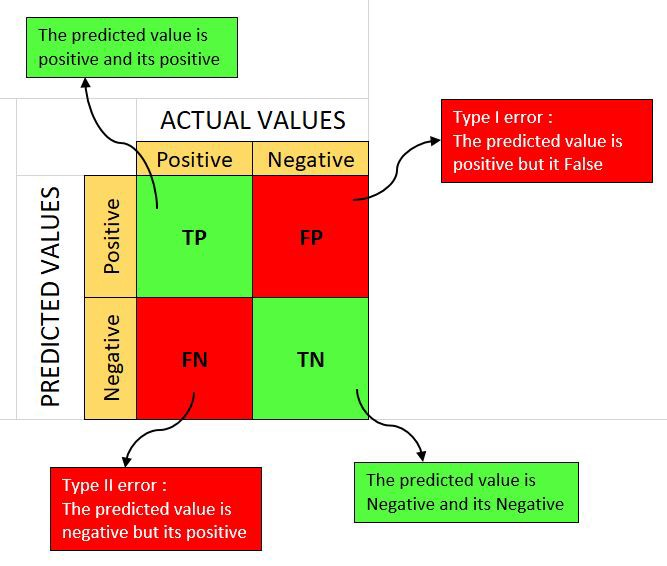

In [65]:
# Making predictions usibg our model
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

In [66]:
conf_matrix = confusion_matrix(y_test, pred)

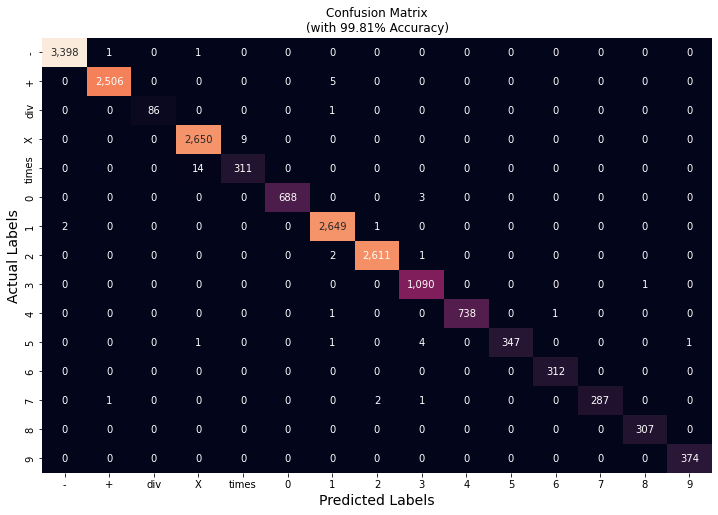

In [67]:
# plotting our confusion matrix

plt.figure(figsize=(12,8))
sns.heatmap(conf_matrix, annot=True, fmt=',g', cbar=False,
           xticklabels=list(map_dict.values()), yticklabels=list(map_dict.values()))

plt.title("Confusion Matrix\n(with 99.71% Accuracy)")
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("Actual Labels", fontsize=14)
plt.show()

We can see our model performed well and correctly classified most of the test images. However, we had some images that were incorrectly classified, so get an idea of how many were misclassified, we are going to plot our confusion matrix again but this time, without the diagonal values.

In [68]:
np.fill_diagonal(conf_matrix, 0)

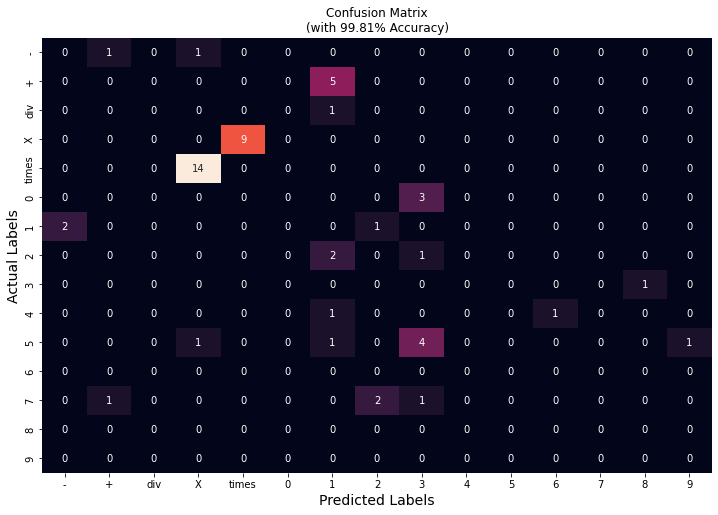

In [69]:
plt.figure(figsize=(12,8))
sns.heatmap(conf_matrix, annot=True, fmt=',g', cbar=False,
           xticklabels=list(map_dict.values()), yticklabels=list(map_dict.values()))

plt.title("Confusion Matrix\n(with 99.71% Accuracy)")
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("Actual Labels", fontsize=14)
plt.show()

Our model misclassified `times` as `X` 16 times, which is understable because both symbols are quite similar, and people have different ways of writing those symbols. `+` was misclassified as `1` 5 times which might be down to just bad hand writing.

### Visualizing the bad predictions

We were able to achieve a high accuracy on the test set, however our model still classified some images wrongly. In this section, we will visualize these wrong predictions.

In [70]:
# making predictions using our model

pred = model.predict(X_test)

In [71]:
# getting the index of our misclassified images
false_idx = np.argwhere(np.argmax(pred, axis=1)!=y_test)

# retrieving the images, false and correct predictions
false_pred = pred[false_idx]
false_test = X_test[false_idx]
false_target = y_test[false_idx]

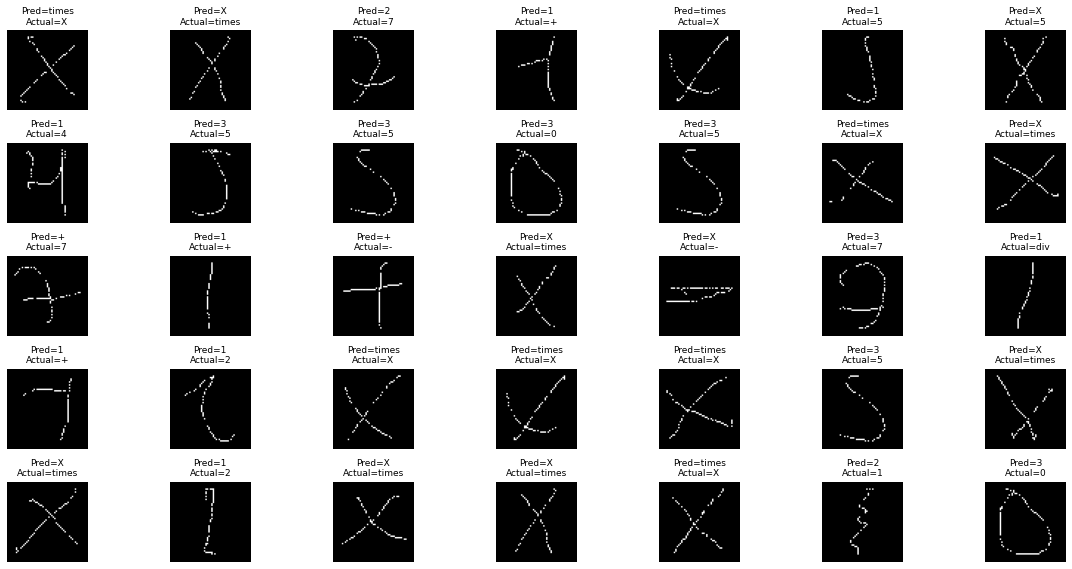

In [74]:
# visualizing the misclassified images, our model predicitions and actual target class

plt.figure(figsize=(16,8))

for i in range(35):
    plt.subplot(5,7,i+1)
    plt.imshow(false_test[i].reshape(55,55,1), cmap='gray')
    plt.axis('off')
    val = np.argmax(false_pred[i])
    plt.title(f"Pred={map_dict[val]}\nActual={map_dict[false_target[i][0]]}", fontsize=9)
plt.subplots_adjust(wspace=1, hspace=0.3)
plt.tight_layout()
plt.show()

To be fair, some of the misclassified images are quite confusing to even us humans. For example take the `X` and `times` classes, they both look similar so its easy to mistake them for one another. Some images however, are just badly written.

## Processing function new images/resizing etc

In this section we are going to create a function that processes an image.
This function will have separate blocks that perform a specific action. We will go through the actions sequentially.

1. First, we need to figure out if the image passed into the function is a filepath or a pixel image.
    * If image is pixel, we need to determine if dimension is less than 3, if it is, we need to add an extra dimesnion for channel.
    
    
2. Then we to know the range of values for pixel values (0 ~ 1 or 0 ~ 255). If the pixel values are within 0 ~ 1, we change the pixel values to either 1 or 0 (i.e black or white. If values are 0 ~ 255, we change pixel values less than 128 to 1 and 1 and the rest to 0.


3. The next block is perhaps the most important part of the function. This block performs image segmentation by partitioning the image into sevaral segments. This is important because our inputs will be basic equations so we need to figure out to segement characters in our inputs.
    * First we start by creating 3 lists, index (idx), imagelist and finallist. Then we go through every column in our image and if the sum of all values at that column is not 0 (i.e has a pixel value) we append the index (i) of that column to our idx list. 
    * Next, at that particular column index (i), we check if the sum of pixel values for the next column (i+1) is 0 and if that condition is met, we segment the image vertically at that point by taking the first and last index values in our idx list and appending it to our imagelist. Else, we continue looping through our columns.
    * While looping through our columns, if we the sum of our pixel values at that point is 0, we clear our list.
    

4. The fourth block checks if sum of pixel in each image is at least 100. Images with pixel sum greater than 100 are trimmed horizontally to get rid of unnecessary pixels and then appended to our finallist.


5. The fifth block padds, add an extra dimension and resizes the image so it's suitable for the model.
    * We first get the width and height of the image by checking its shape.
    * if the width and height are inequal, we pad the image to make both equal.
    * Padding the image reduces the dimension, so we need to add an extra dimesion.
    * Finally, we use tf.image to resize the image to (55, 55) the shape the model was trained on, and then convert it to a numpy array.
    

6. Finally, we convert pixel values to 0 or 1 because tf.image.resize rescales our pixels hence most of the values are no longer 1.

In [14]:
def Process_image(file):
    # 1. Deteremines if image is filepath or pixel values
    try:
        # if sum of pixel is more than 1,then we know its a pixel
        if np.sum(file) > 1:
            image = file
            # if image dimension is less than 3 (i.e == 2) we will need to add and extra dimension for channels (Black&White)
            if image.ndim < 3:
                image = image[:,:,np.newaxis]
    except Exception as e:
        # if image is filepath, we read it, which converts it to pixel values
        image = mpig.imread(file)
    
    # we visualize the image
    plt.axis('off')
    plt.imshow(image)
    
    
    # 2. Determines if maximum pixel is 1 or 255
    if image.max() == 1.0:
        image = np.where(image==0,1,0)
    else:
        image = np.where(image<128,1,0)
        
    # 3. Handles Image Segmentation
    idx = []
    imagelist = []
    finallist = []
    for i in range(image.shape[1]-2):
        if np.sum(image[:,i,0])!=0:
            idx.append(i)
            if np.sum(image[:,i+1,0])==0:
                imagelist.append(image[:,idx[0]:idx[-1],0])
            else:
                continue

        elif np.sum(image[:,i,0])==0:
            idx=[]

    
    # 4. Deletes zero-value arrays, checks if sum of pixel in each image is at least 500 and trims the pixels-horizontally
    for i in range(len(imagelist)):
        #print(np.sum(imagelist[i]))
        if np.sum(imagelist[i]) == 0 or np.sum(imagelist[i])<100:
            continue
        else:
            imagelist[i] = imagelist[i][(imagelist[i]!=0).any(axis=1)]
            finallist.append(imagelist[i])
                
    
    # 5. Handles padding, adding extra dimension and resizes the image so it's suitable for the model
    for i in range(len(finallist)):
        width = finallist[i].shape[0]
        heigth = finallist[i].shape[1]
        
        if width > heigth:
            pad_size = int((width - heigth)/2) + 10
            finallist[i] = np.pad(finallist[i], ((10,10),(pad_size, pad_size)), 
                                  mode='constant')
        else:
            pad_size = int((heigth - width)/2) + 10
            finallist[i] = np.pad(finallist[i], ((pad_size,pad_size),(10, 10)), 
                                  mode='constant')
        finallist[i] = finallist[i][:,:,np.newaxis]
        finallist[i] = tf.image.resize(finallist[i], (55,55)).numpy()


    # 6. converts pixels to black and white
    for i in range(len(finallist)):
        finallist[i] = np.where(finallist[i]==0,0,1)
    
    return np.array(finallist)

## Testing Processing function with sample handwritten equations

In this section we will processing some sample handwritten equtions i found and making predictions on them. 

***`N.B: It's worth mentioning before we begin, that some symbols used in training our model are different from those in the sample handwritten equations e.g 7.`***

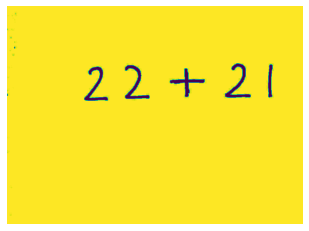

Model Predictions:  ['2', '2', '+', '2', '1']
1


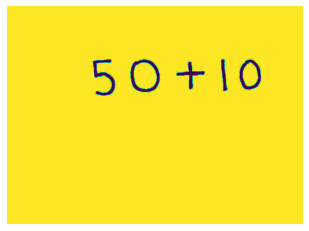

Model Predictions:  ['5', '0', '+', '1', '0']
2


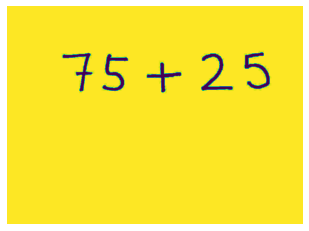

Model Predictions:  ['7', '5', '+', '2', '5']
3


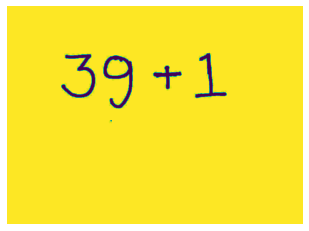

Model Predictions:  ['3', '9', '+', '2']
4


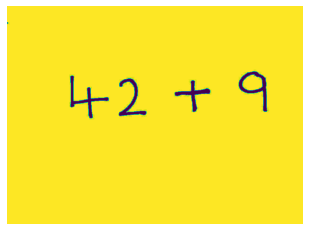

Model Predictions:  ['4', '2', '+', '9']
5


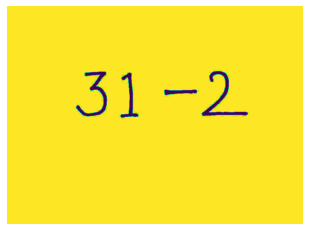

Model Predictions:  ['3', '1', '-', '2']
6


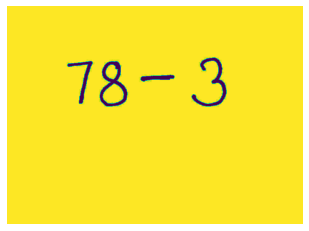

Model Predictions:  ['7', '8', '-', '3']
7


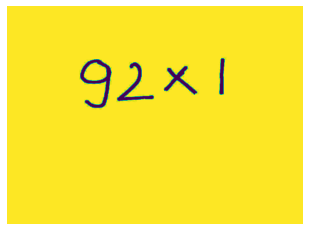

Model Predictions:  ['9', '2', 'X', '1']
8


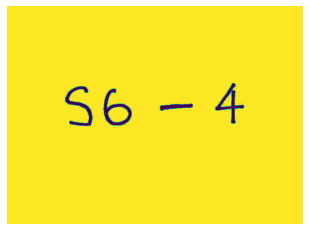

Model Predictions:  ['5', '6', '-', '4']
9


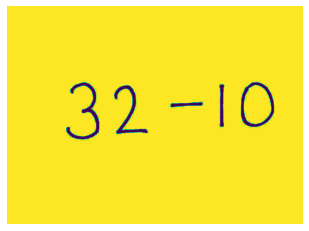

Model Predictions:  ['3', '2', '-', '1', '0']
10


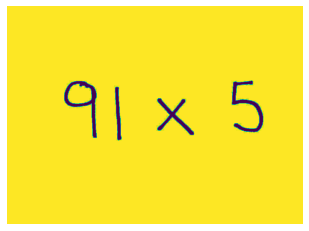

Model Predictions:  ['9', '1', 'X', '5']
11


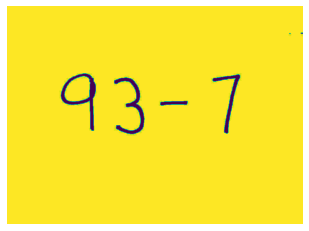

Model Predictions:  ['9', '3', '-', '7']
12


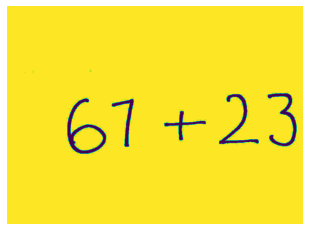

Model Predictions:  ['6', '7', '+', '2', '3']
13


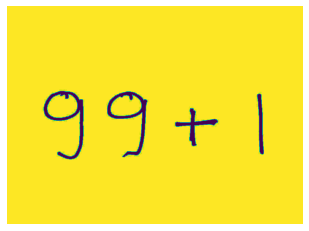

Model Predictions:  ['9', '9', '+', '1']
14


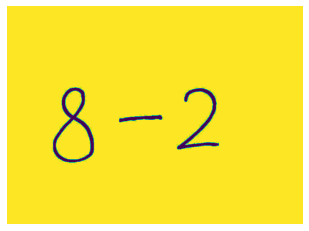

Model Predictions:  ['8', '-', '2']
15


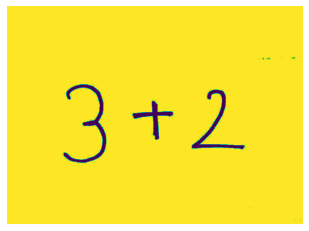

Model Predictions:  ['3', '+', '2']
16


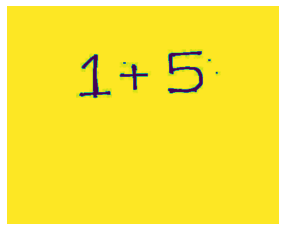

Model Predictions:  ['1', '+', '5']
17


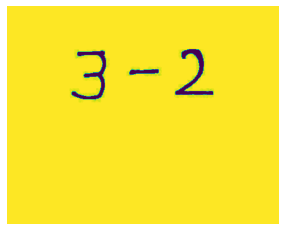

Model Predictions:  ['3', '-', '2']
18


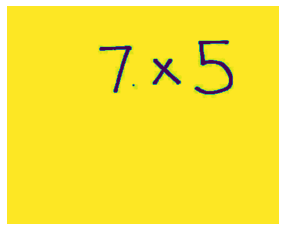

Model Predictions:  ['7', 'X', '5']
19


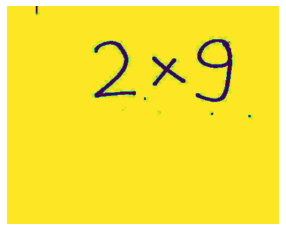

Model Predictions:  ['2', 'X', '9']
20


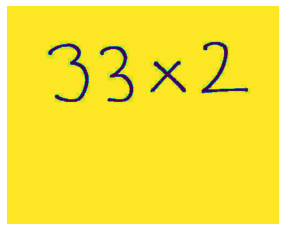

Model Predictions:  ['3', '3', 'X', '2']
21


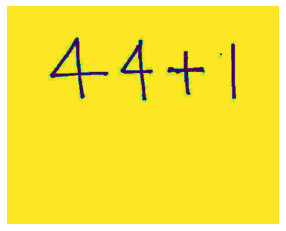

Model Predictions:  ['+', '4', '+', '1']
22


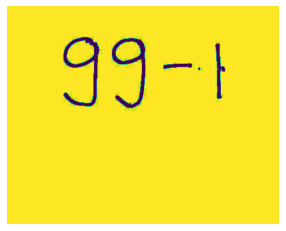

Model Predictions:  ['9', '9', '-', '1']
23


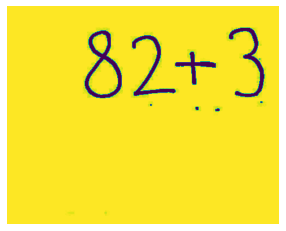

Model Predictions:  ['8', 'X', '3']
24


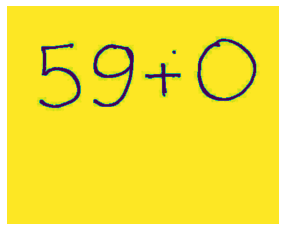

Model Predictions:  ['5', '5', '+', '0']
25


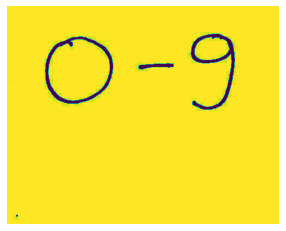

Model Predictions:  ['0', '-', '9']
26


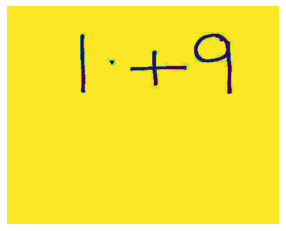

Model Predictions:  ['1', '-', '9']
27


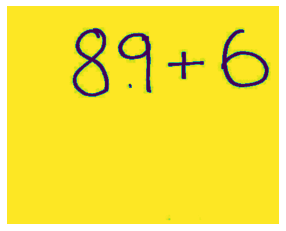

Model Predictions:  ['8', '9', '+', '6']
28


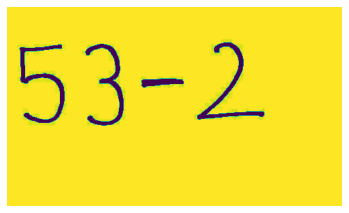

Model Predictions:  ['5', '3', '-', '2']
29


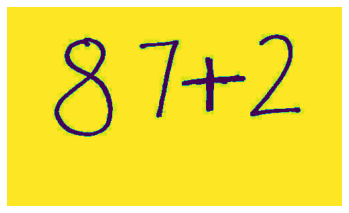

Model Predictions:  ['8', '7', '+', '2']
30


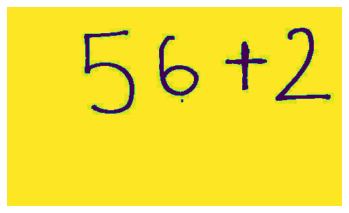

Model Predictions:  ['5', '6', '+', '2']
31


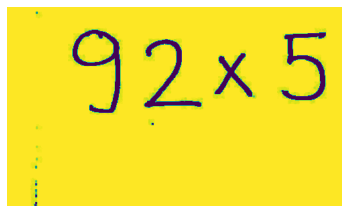

Model Predictions:  ['9', '2', 'X', '5']
32


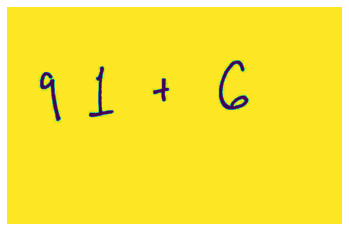

Model Predictions:  ['1', '1', '3', '6']
33


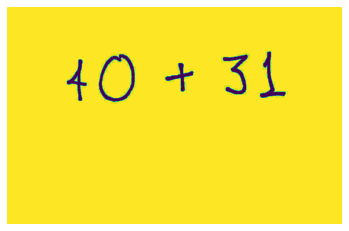

Model Predictions:  ['1', '0', '+', '3', '1']
34


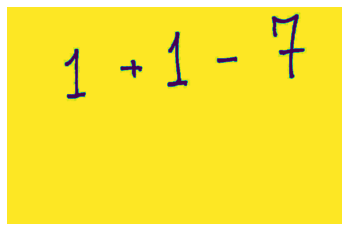

Model Predictions:  ['1', '+', '1', '-', '7']
35


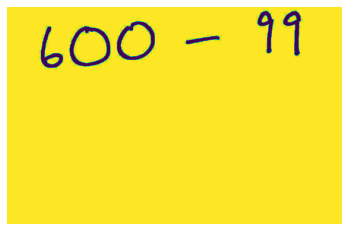

Model Predictions:  ['6', '0', '0', '-', '9', '9']
36


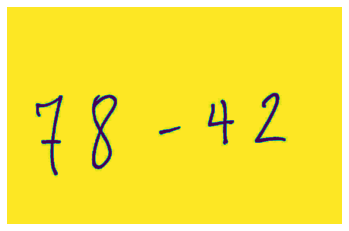

Model Predictions:  ['3', '8', '2', '4', '2']
37


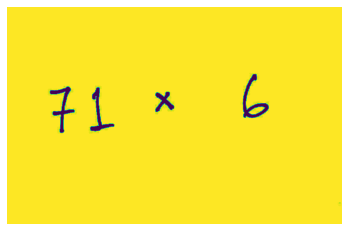

Model Predictions:  ['7', '1', 'X', '6']
38


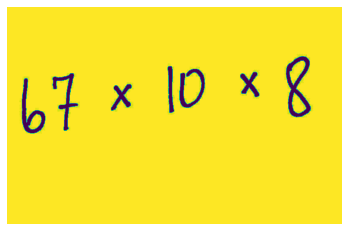

Model Predictions:  ['6', '7', 'X', '1', '0', 'X', '8']
39


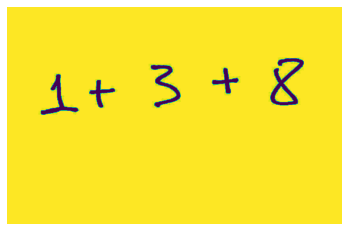

Model Predictions:  ['1', '+', '3', '2', '8']
40


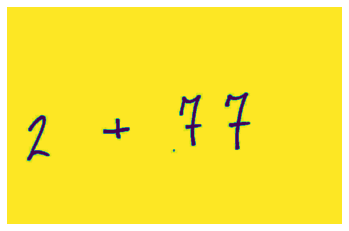

Model Predictions:  ['2', '+', '7', '7']
41


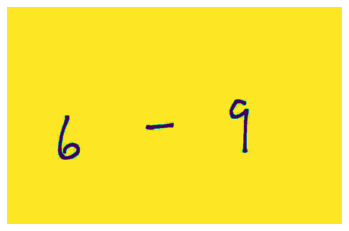

Model Predictions:  ['6', '-', '9']
42


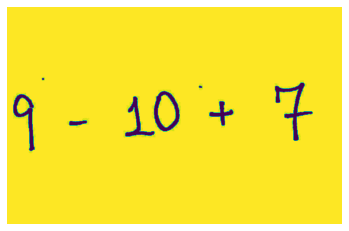

Model Predictions:  ['9', '-', 'X', '2', '7']
43


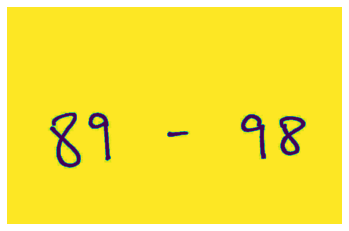

Model Predictions:  ['8', '9', '-', '9', '8']
44


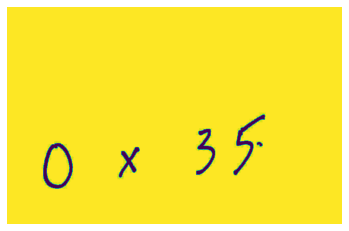

Model Predictions:  ['0', 'X', '3', '5']
45


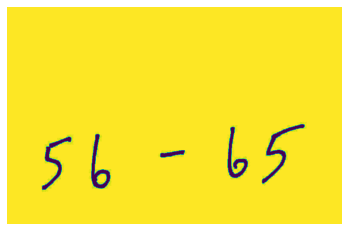

Model Predictions:  ['5', '6', '-', '6', '5']
46


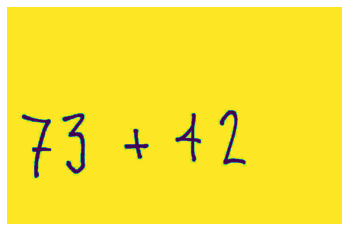

Model Predictions:  ['7', '3', '2', '1', '2']
47


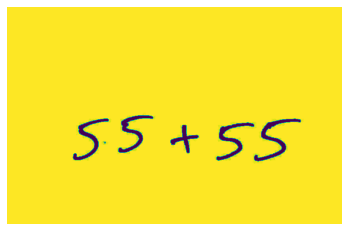

Model Predictions:  ['5', '5', '+', 'X']
48


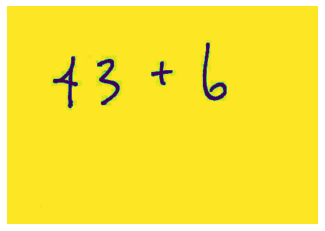

Model Predictions:  ['1', '3', '+', '6']
49


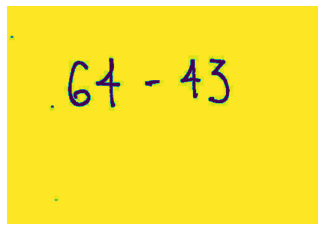

Model Predictions:  ['6', '1', '+', '1', '3']
50


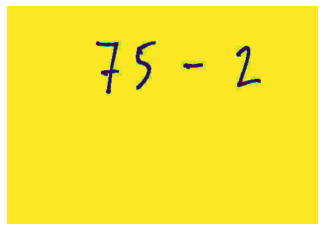

Model Predictions:  ['3', '5', '2', '2']
51


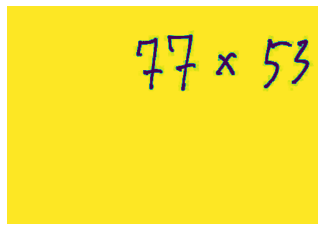

Model Predictions:  ['7', '7', 'X', '5']
52


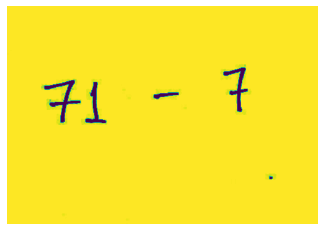

Model Predictions:  ['7', '1', '-', '7']
53


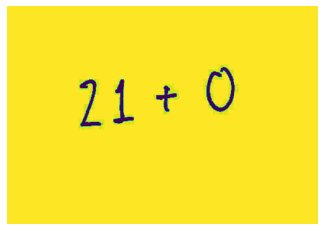

Model Predictions:  ['2', '1', '+', '0']
54


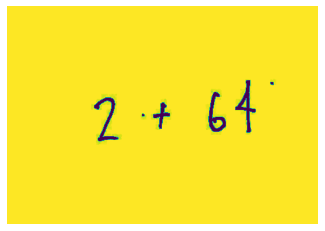

Model Predictions:  ['2', '4', '6', '1']
55


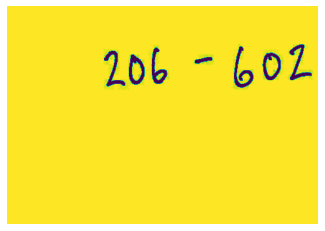

Model Predictions:  ['2', '0', '5', '2', '6', '0', '2']
56


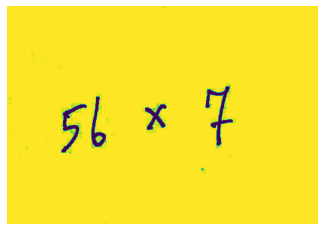

Model Predictions:  ['5', '8', 'X', '7']
57


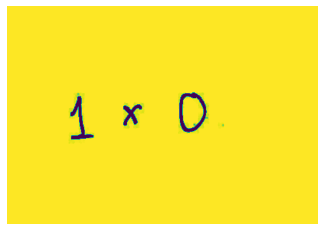

Model Predictions:  ['1', 'X', '0']
58


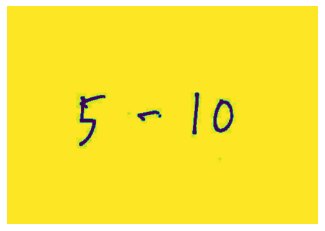

Model Predictions:  ['5', '+', '1', '0']
59


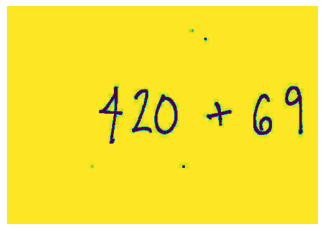

Model Predictions:  ['1', '2', '0', '7', '5', '9']
60


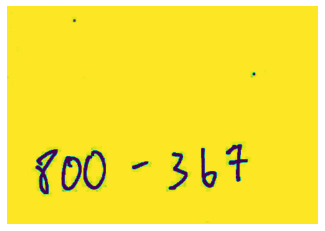

Model Predictions:  ['5', '0', '0', '2', '3', '3', '7']
61


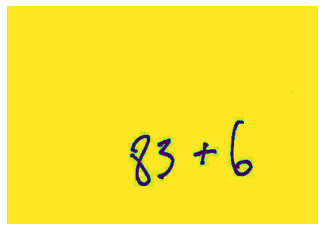

Model Predictions:  ['9', '3', '+', '6']
62


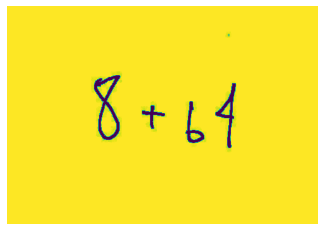

Model Predictions:  ['8', '+', '6', '1']
63


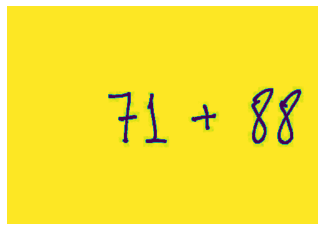

Model Predictions:  ['7', '1', '+', '8', '8']
64


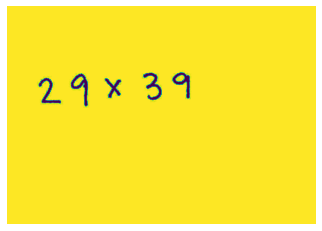

Model Predictions:  ['2', '9', 'X', '3', '9']
65


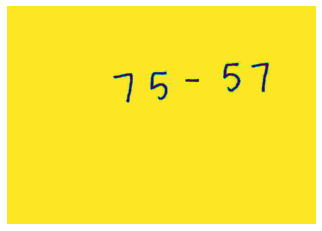

Model Predictions:  ['7', '5', '-', '5', '7']
66


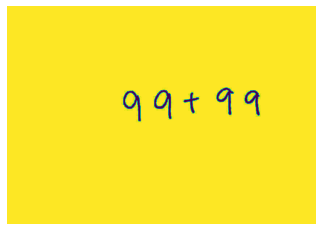

Model Predictions:  ['9', '9', '+', '9', '9']
67


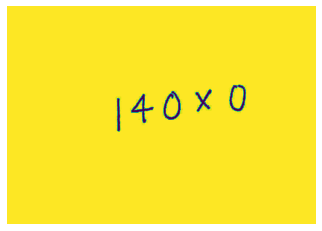

Model Predictions:  ['1', '+', '0', 'X', '4']
68


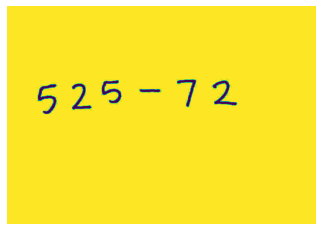

Model Predictions:  ['5', '2', '5', '-', '7', '2']
69


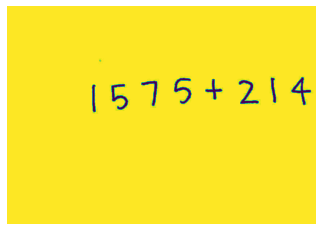

Model Predictions:  ['1', '5', '7', '5', '+', '2', '1', '4']
70


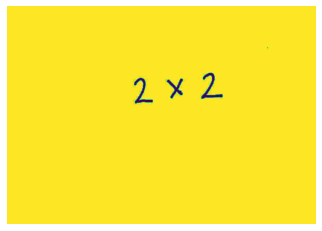

Model Predictions:  ['2', 'X', '2']
71


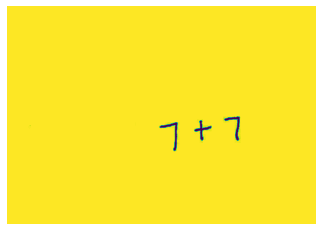

Model Predictions:  ['1', '+', '7']
72


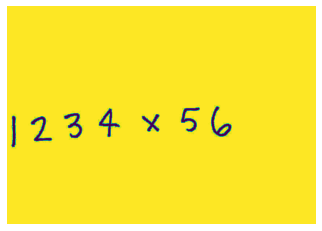

Model Predictions:  ['1', '2', '3', '4', 'X', '5', '6']
73


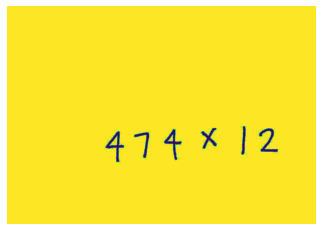

Model Predictions:  ['1', '1', '+', 'X', '1', '2']
74


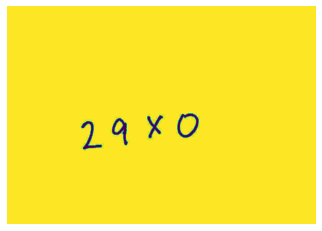

Model Predictions:  ['2', '9', 'X', '0']
75


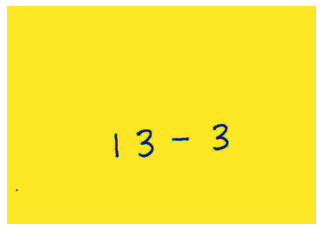

Model Predictions:  ['1', '3', '-', '3']
76


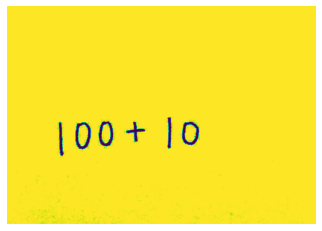

Model Predictions:  ['1', '0', '0', '+', '1', '0']
77


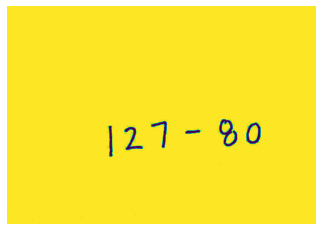

Model Predictions:  ['1', '2', '1', '-', '7', '0']
78


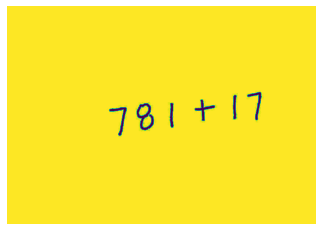

Model Predictions:  ['7', '8', '1', '+', '1', '7']
79


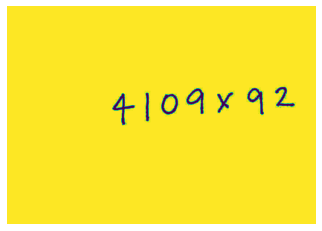

Model Predictions:  ['4', '1', '0', '9', 'X', '9', '2']
80


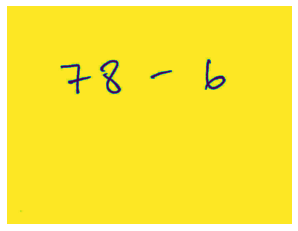

Model Predictions:  ['7', '8', '2', '3']
81


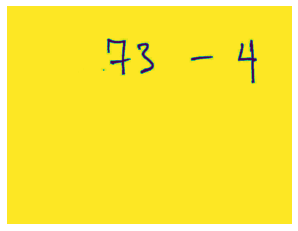

Model Predictions:  ['7', '3', '-', '4']
82


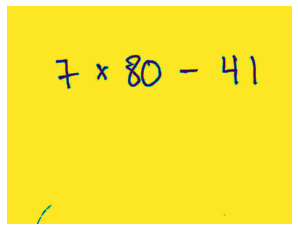

Model Predictions:  ['7', 'X', '8', '0', '-', '9', '1']
83


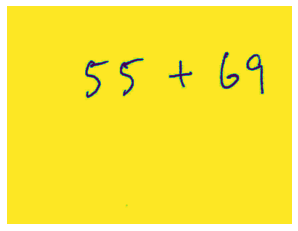

Model Predictions:  ['5', '5', '+', '6', '9']
84


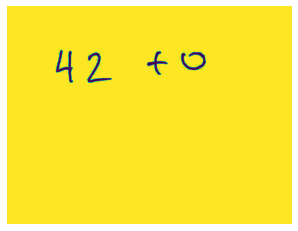

Model Predictions:  ['4', '2', '+', '0']
85


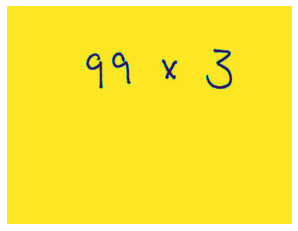

Model Predictions:  ['9', '9', 'X', '3']
86


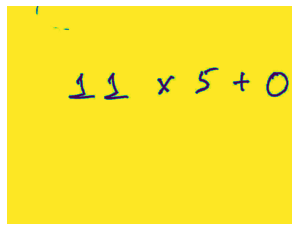

Model Predictions:  ['2', '2', 'X', '5', '2', '0']
87


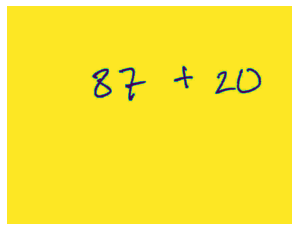

Model Predictions:  ['8', '7', '2', '2', '0']
88


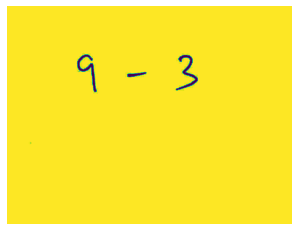

Model Predictions:  ['9', '-', '3']
89


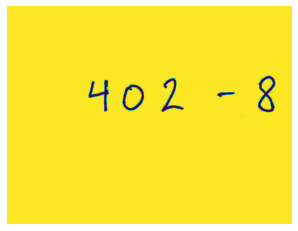

Model Predictions:  ['4', '0', '2', '-', '8']
90


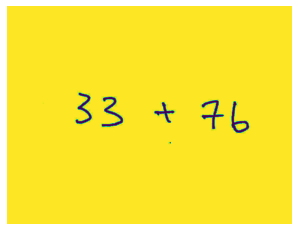

Model Predictions:  ['3', '3', '+', '7', '6']
91


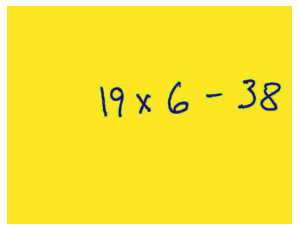

Model Predictions:  ['1', '9', 'X', '6', '-', '3', '8']
92


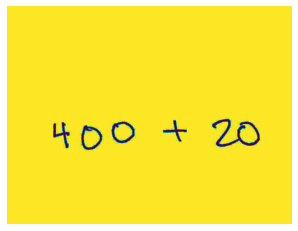

Model Predictions:  ['4', '0', '0', '1', 'X']
93


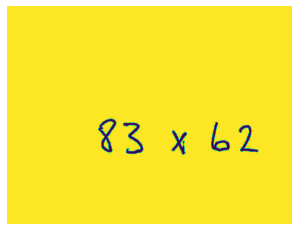

Model Predictions:  ['8', '3', 'X', '6', '2']
94


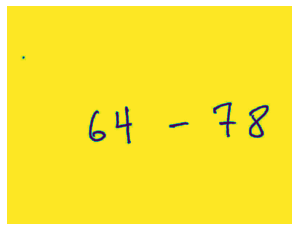

Model Predictions:  ['6', '4', '-', '7', '8']
95


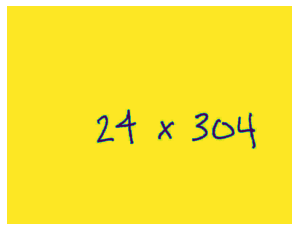

Model Predictions:  ['2', '+', 'X', '3', '0', '4']
96


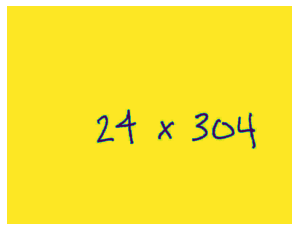

In [19]:
# loading the images from the root directory

counter = 0
for i in range(1,7):
    path = "Equations_images_" + str(i) + ".npy"
    data = np.load(path, allow_pickle=True)
    for image in data:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        vals = model.predict(Process_image(image))
        vals = np.argmax(vals, axis=1)
        mylist = []
        counter += 1
        for x in vals:
            mylist.append(map_dict[x])
        print("Model Predictions: ",mylist)

Our model performed well on most of the images **(~70%)**, however there were cases where the model made bad predictions. This poor performance on most of the misclassified images were down to the how the equations were written, or the difference between the data the model was trained on, and the handwritten equations.

## SymPy

In this section we will be building our function for calculating the handwritten equation based on our model predictions on images.

The function will iterate through our list of model predictions to find how many operators we have and what type of operator it is. Next, it will separate our model predictions by our operators then perform our calculation.  

***`N.B: The function can only evaluate an equation with at most 2 operators.`***

In [16]:
def Calculate(eq_list):
    import operator
    from string import punctuation
    
    # list of acceptable operators for this project
    ops = {
    '+' : operator.add,
    '-' : operator.sub,
    '*' : operator.mul,
    '/' : operator.truediv,
    '%' : operator.mod,
    '^' : operator.xor,
    }
    
    punct_list = []
    string_ = "".join(eq_list)
    
    # finding all operators in the image/list
    for char in eq_list:
        if char in list(punctuation):
            punct_list.append(char)
        elif char == 'X' or char == 'times':
            punct_list.append(char)

    
    # if/else statement with try-except block to evaluate images and handle exceptions/errors
    if len(punct_list) == 2:
        try:
            lhs, (mid, rhs) = string_.split(punct_list[0])[0], (string_.split(punct_list[0])[1].split(punct_list[1])[0], string_.split(punct_list[0])[1].split(punct_list[1])[1])
            lhs, mid, rhs = int(lhs), int(mid), int(rhs)
            if 'X' in punct_list or 'times' in punct_list:
                punct_list = np.where((np.array(punct_list)=='X')|(np.array(punct_list)=='times'), '*', np.array(punct_list)).tolist()
            a = ops[punct_list[0]](lhs,mid)
            solution = ops[punct_list[1]](a, rhs)
        except Exception as e:
            print('Please Look at the Instructions and Examples to input the appropriate equation.\nThanks!')

    elif len(punct_list) == 1:
        try:
            lhs, rhs = string_.split(punct_list[0])[0], string_.split(punct_list[0])[1]
            lhs, rhs = int(lhs), int(rhs)
            if 'X' in punct_list or 'times' in punct_list:
                punct_list = np.where((np.array(punct_list)=='X')|(np.array(punct_list)=='times'), '*', np.array(punct_list)).tolist()
            solution = ops[punct_list[0]](lhs, rhs)
        except Exception as e:
            print('Please Look at the Instructions and Examples to input the appropriate equation.\nThanks!')

    else:
        print('Please Look at the Instructions and Examples to input the appropriate equation.\nThanks!')
    
    
    # try-except block to handle UboundLocalError that might arise due to no available solution 
    # i.e(executed except blocks above)
    try:
        return solution
    except UnboundLocalError:
        pass
    

#### Testing our Function

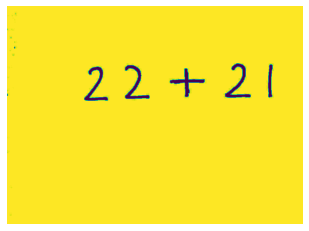

Model Prediction: ['2', '2', '+', '2', '1']
Solution: 43


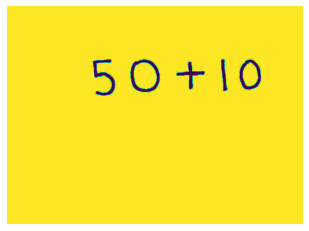

Model Prediction: ['5', '0', '+', '1', '0']
Solution: 60


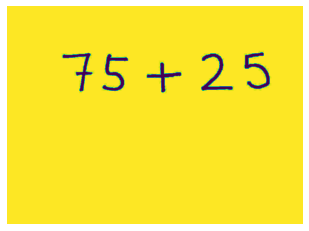

Model Prediction: ['7', '5', '+', '2', '5']
Solution: 100


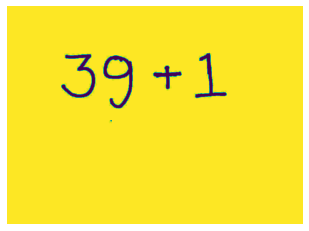

Model Prediction: ['3', '9', '+', '2']
Solution: 41


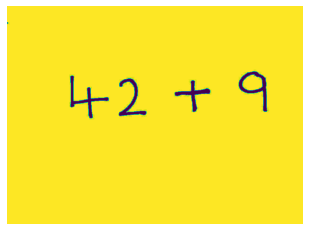

Model Prediction: ['4', '2', '+', '9']
Solution: 51


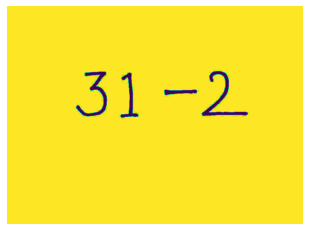

Model Prediction: ['3', '1', '-', '2']
Solution: 29


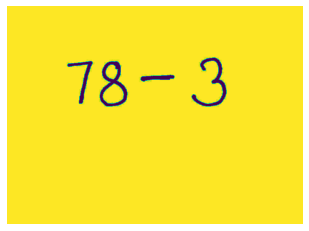

Model Prediction: ['7', '8', '-', '3']
Solution: 75


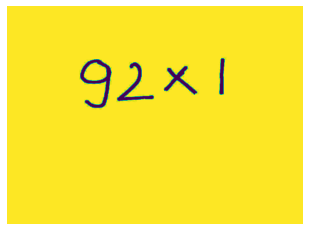

Model Prediction: ['9', '2', 'X', '1']
Solution: 92


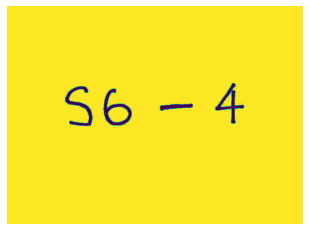

Model Prediction: ['5', '6', '-', '4']
Solution: 52


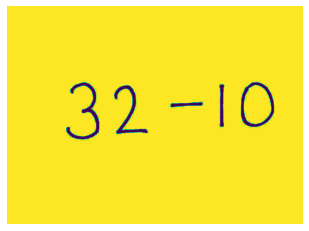

Model Prediction: ['3', '2', '-', '1', '0']
Solution: 22


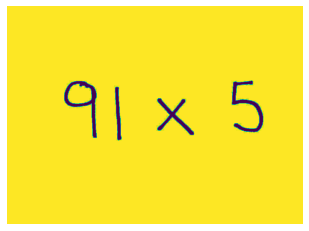

Model Prediction: ['9', '1', 'X', '5']
Solution: 455


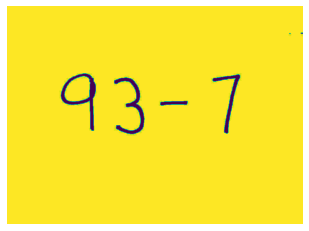

Model Prediction: ['9', '3', '-', '7']
Solution: 86


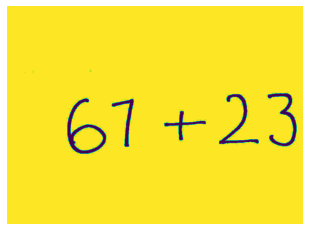

Model Prediction: ['6', '7', '+', '2', '3']
Solution: 90


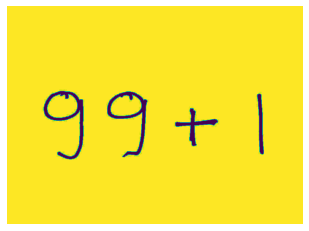

Model Prediction: ['9', '9', '+', '1']
Solution: 100


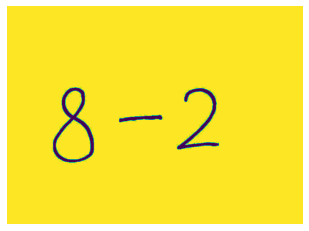

Model Prediction: ['8', '-', '2']
Solution: 6


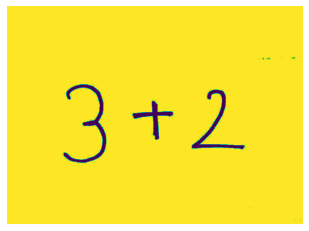

Model Prediction: ['3', '+', '2']
Solution: 5


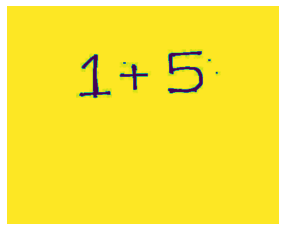

Model Prediction: ['1', '+', '5']
Solution: 6


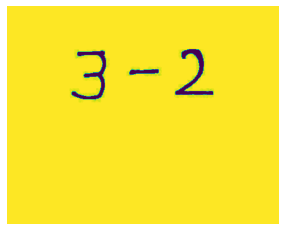

Model Prediction: ['3', '-', '2']
Solution: 1


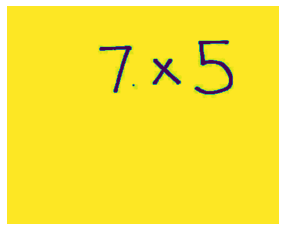

Model Prediction: ['7', 'X', '5']
Solution: 35


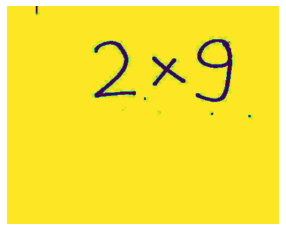

Model Prediction: ['2', 'X', '9']
Solution: 18


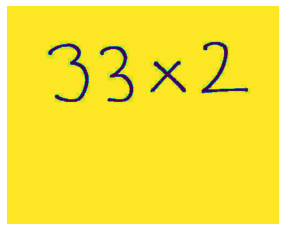

Model Prediction: ['3', '3', 'X', '2']
Solution: 66


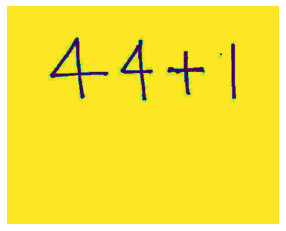

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['+', '4', '+', '1']
Solution: None


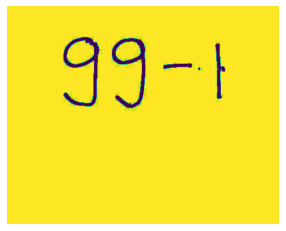

Model Prediction: ['9', '9', '-', '1']
Solution: 98


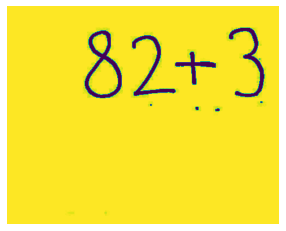

Model Prediction: ['8', 'X', '3']
Solution: 24


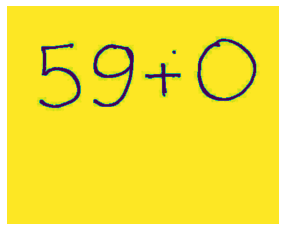

Model Prediction: ['5', '5', '+', '0']
Solution: 55


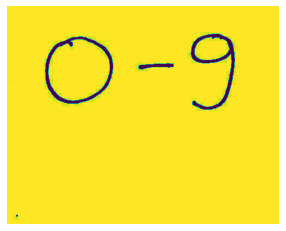

Model Prediction: ['0', '-', '9']
Solution: -9


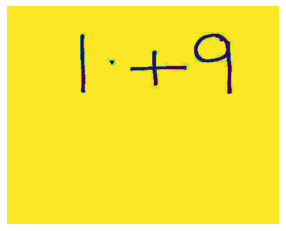

Model Prediction: ['1', '-', '9']
Solution: -8


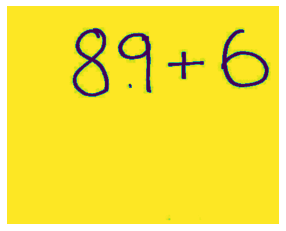

Model Prediction: ['8', '9', '+', '6']
Solution: 95


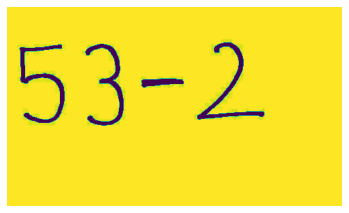

Model Prediction: ['5', '3', '-', '2']
Solution: 51


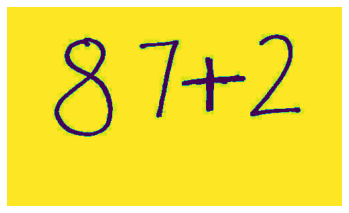

Model Prediction: ['8', '7', '+', '2']
Solution: 89


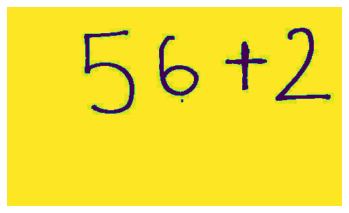

Model Prediction: ['5', '6', '+', '2']
Solution: 58


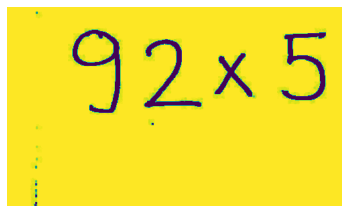

Model Prediction: ['9', '2', 'X', '5']
Solution: 460


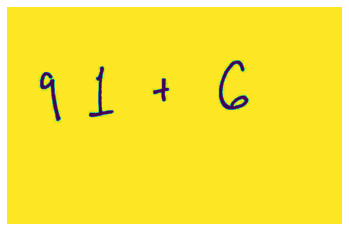

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['1', '1', '3', '6']
Solution: None


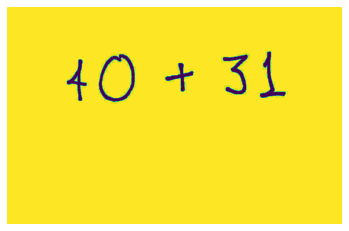

Model Prediction: ['1', '0', '+', '3', '1']
Solution: 41


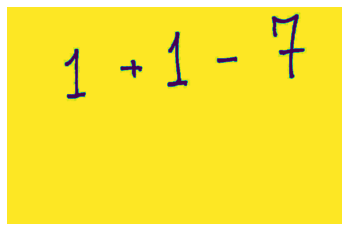

Model Prediction: ['1', '+', '1', '-', '7']
Solution: -5


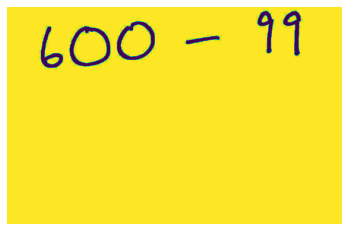

Model Prediction: ['6', '0', '0', '-', '9', '9']
Solution: 501


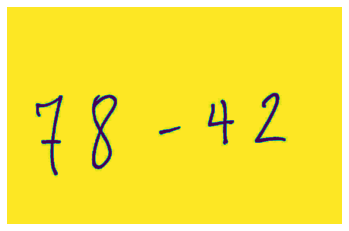

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['3', '8', '2', '4', '2']
Solution: None


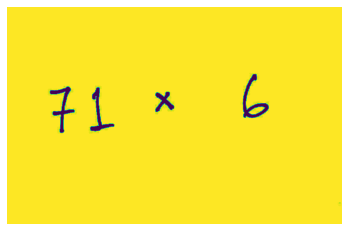

Model Prediction: ['7', '1', 'X', '6']
Solution: 426


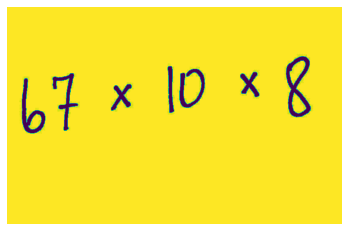

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['6', '7', 'X', '1', '0', 'X', '8']
Solution: None


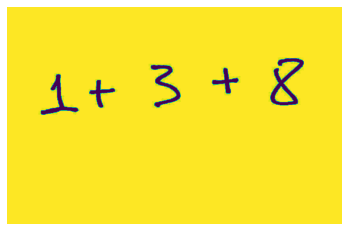

Model Prediction: ['1', '+', '3', '2', '8']
Solution: 329


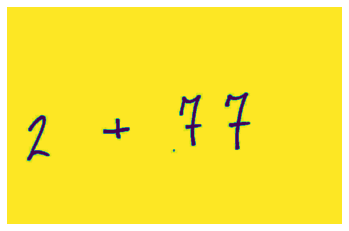

Model Prediction: ['2', '+', '7', '7']
Solution: 79


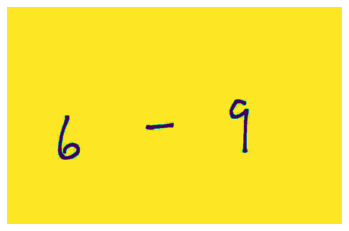

Model Prediction: ['6', '-', '9']
Solution: -3


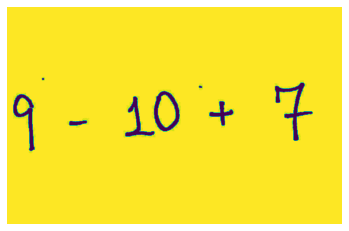

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['9', '-', 'X', '2', '7']
Solution: None


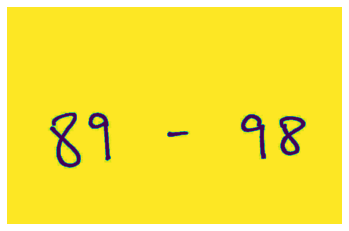

Model Prediction: ['8', '9', '-', '9', '8']
Solution: -9


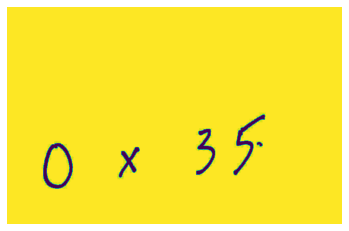

Model Prediction: ['0', 'X', '3', '5']
Solution: 0


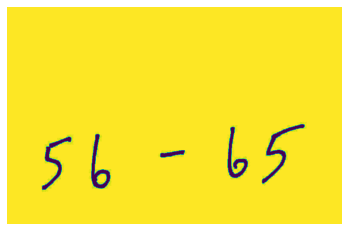

Model Prediction: ['5', '6', '-', '6', '5']
Solution: -9


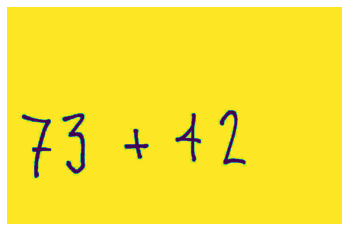

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['7', '3', '2', '1', '2']
Solution: None


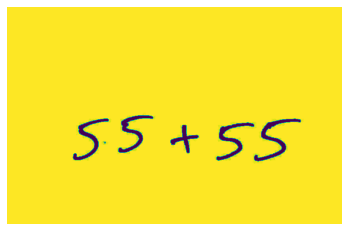

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['5', '5', '+', 'X']
Solution: None


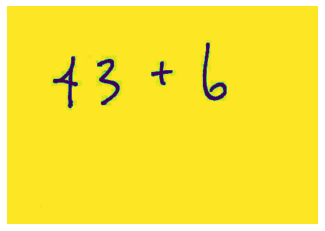

Model Prediction: ['1', '3', '+', '6']
Solution: 19


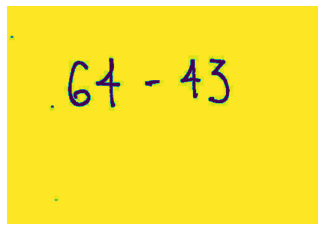

Model Prediction: ['6', '1', '+', '1', '3']
Solution: 74


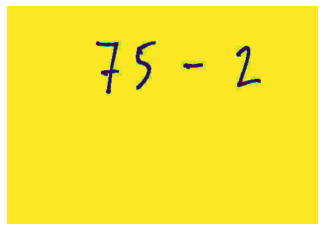

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['3', '5', '2', '2']
Solution: None


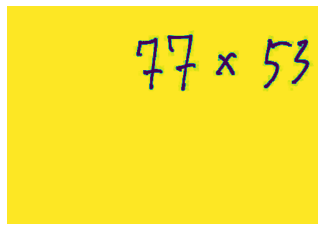

Model Prediction: ['7', '7', 'X', '5']
Solution: 385


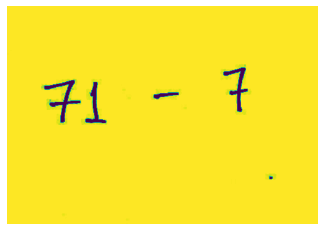

Model Prediction: ['7', '1', '-', '7']
Solution: 64


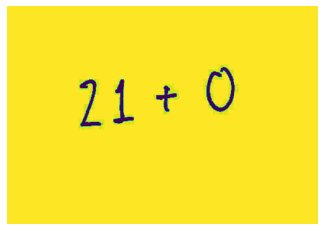

Model Prediction: ['2', '1', '+', '0']
Solution: 21


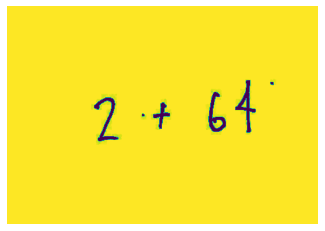

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['2', '4', '6', '1']
Solution: None


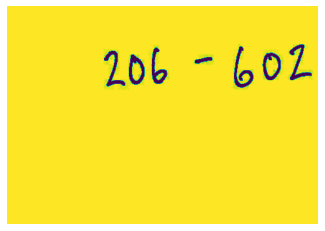

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['2', '0', '5', '2', '6', '0', '2']
Solution: None


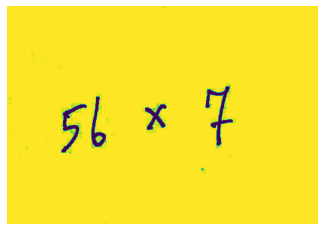

Model Prediction: ['5', '8', 'X', '7']
Solution: 406


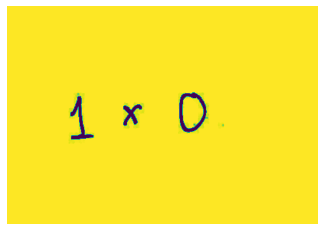

Model Prediction: ['1', 'X', '0']
Solution: 0


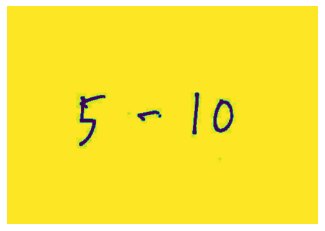

Model Prediction: ['5', '+', '1', '0']
Solution: 15


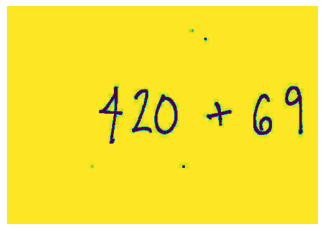

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['1', '2', '0', '7', '5', '9']
Solution: None


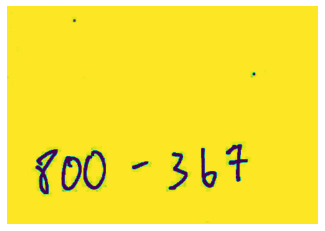

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['5', '0', '0', '2', '3', '3', '7']
Solution: None


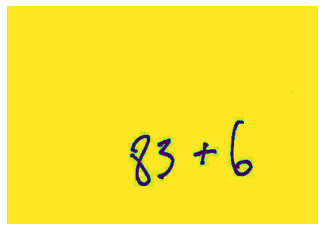

Model Prediction: ['9', '3', '+', '6']
Solution: 99


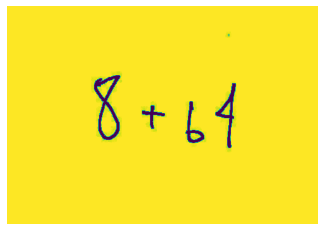

Model Prediction: ['8', '+', '6', '1']
Solution: 69


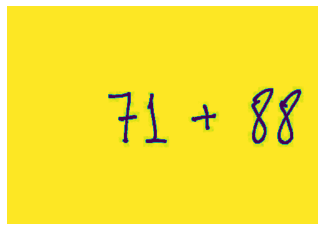

Model Prediction: ['7', '1', '+', '8', '8']
Solution: 159


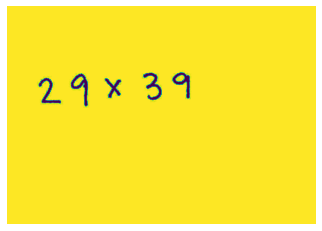

Model Prediction: ['2', '9', 'X', '3', '9']
Solution: 1131


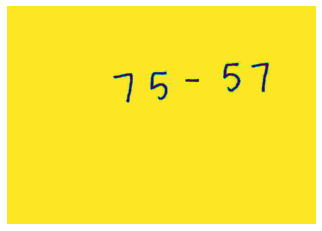

Model Prediction: ['7', '5', '-', '5', '7']
Solution: 18


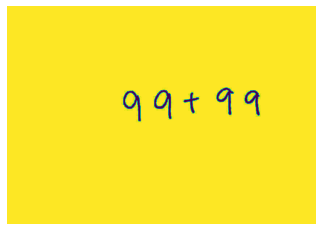

Model Prediction: ['9', '9', '+', '9', '9']
Solution: 198


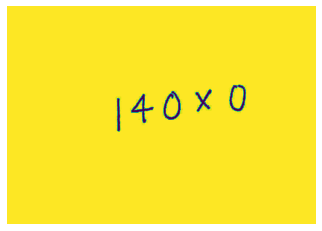

Model Prediction: ['1', '+', '0', 'X', '4']
Solution: 4


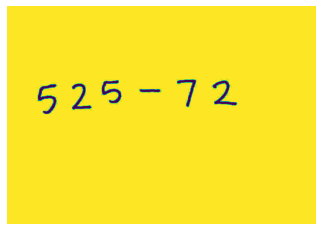

Model Prediction: ['5', '2', '5', '-', '7', '2']
Solution: 453


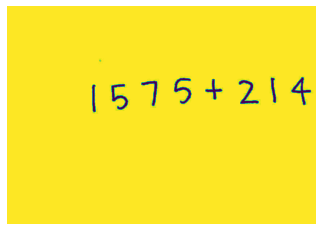

Model Prediction: ['1', '5', '7', '5', '+', '2', '1', '4']
Solution: 1789


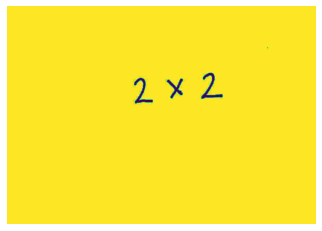

Model Prediction: ['2', 'X', '2']
Solution: 4


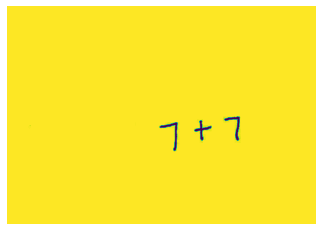

Model Prediction: ['1', '+', '7']
Solution: 8


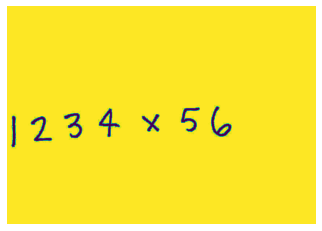

Model Prediction: ['1', '2', '3', '4', 'X', '5', '6']
Solution: 69104


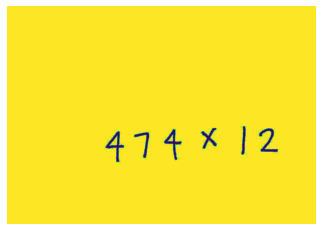

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['1', '1', '+', 'X', '1', '2']
Solution: None


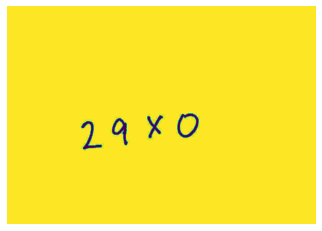

Model Prediction: ['2', '9', 'X', '0']
Solution: 0


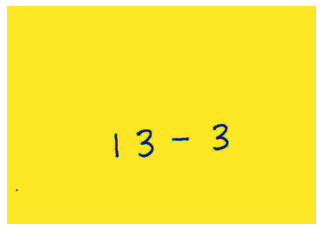

Model Prediction: ['1', '3', '-', '3']
Solution: 10


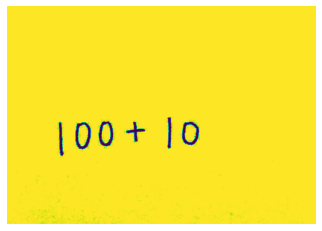

Model Prediction: ['1', '0', '0', '+', '1', '0']
Solution: 110


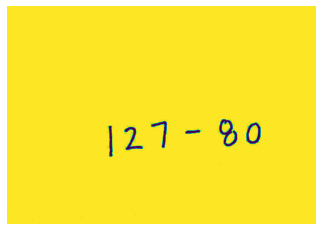

Model Prediction: ['1', '2', '1', '-', '7', '0']
Solution: 51


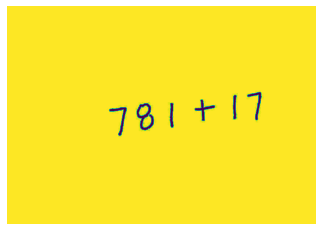

Model Prediction: ['7', '8', '1', '+', '1', '7']
Solution: 798


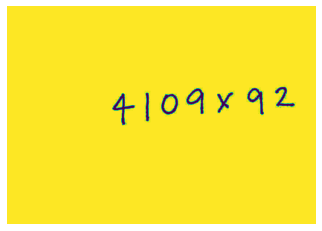

Model Prediction: ['4', '1', '0', '9', 'X', '9', '2']
Solution: 378028


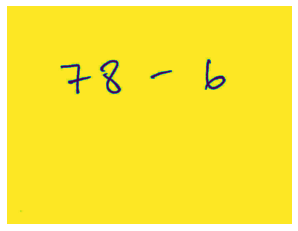

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['7', '8', '2', '3']
Solution: None


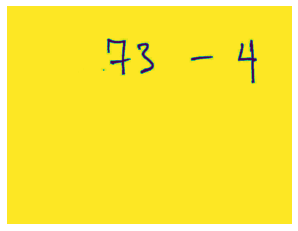

Model Prediction: ['7', '3', '-', '4']
Solution: 69


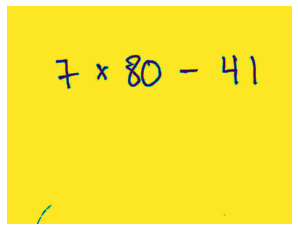

Model Prediction: ['7', 'X', '8', '0', '-', '9', '1']
Solution: 469


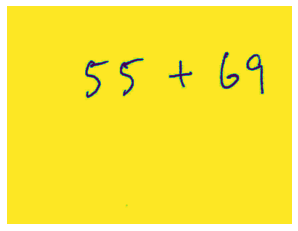

Model Prediction: ['5', '5', '+', '6', '9']
Solution: 124


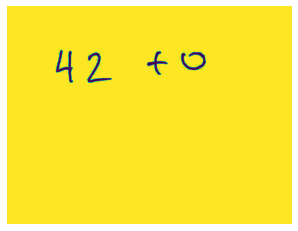

Model Prediction: ['4', '2', '+', '0']
Solution: 42


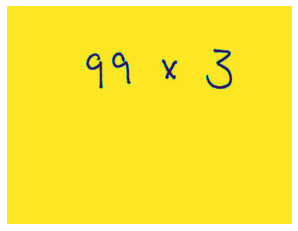

Model Prediction: ['9', '9', 'X', '3']
Solution: 297


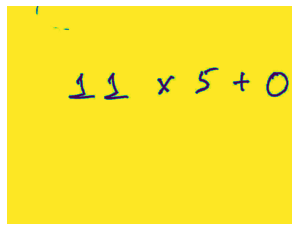

Model Prediction: ['2', '2', 'X', '5', '2', '0']
Solution: 11440


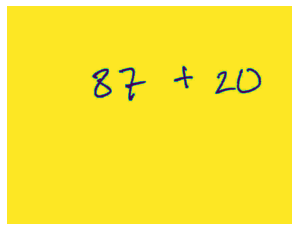

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['8', '7', '2', '2', '0']
Solution: None


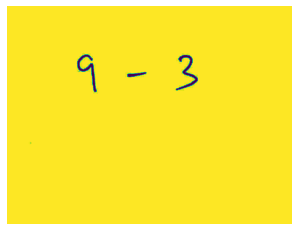

Model Prediction: ['9', '-', '3']
Solution: 6


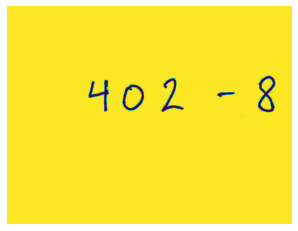

Model Prediction: ['4', '0', '2', '-', '8']
Solution: 394


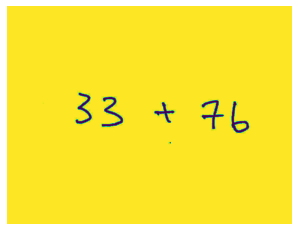

Model Prediction: ['3', '3', '+', '7', '6']
Solution: 109


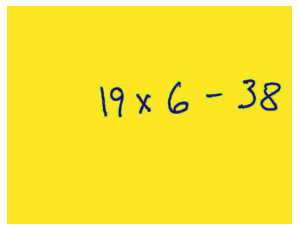

Model Prediction: ['1', '9', 'X', '6', '-', '3', '8']
Solution: 76


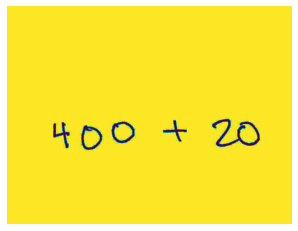

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['4', '0', '0', '1', 'X']
Solution: None


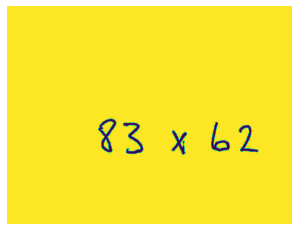

Model Prediction: ['8', '3', 'X', '6', '2']
Solution: 5146


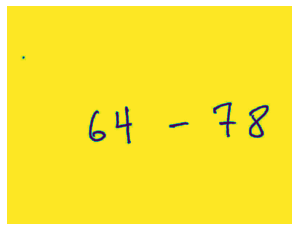

Model Prediction: ['6', '4', '-', '7', '8']
Solution: -14


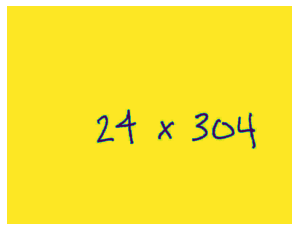

Please Look at the Instructions and Examples to input the appropriate equation.
Thanks!
Model Prediction: ['2', '+', 'X', '3', '0', '4']
Solution: None


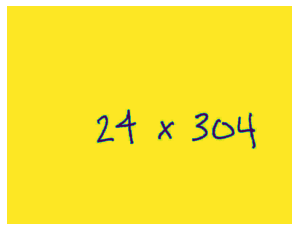

In [22]:
for i in range(1,7):
    path = "Equations_images_" + str(i) + ".npy"
    data = np.load(path, allow_pickle=True)
    for image in data:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        vals = model.predict(Process_image(image))
        vals = np.argmax(vals, axis=1)
        mylist = []
        for x in vals:
            mylist.append(map_dict[x])
        ans = Calculate(mylist)
        print(f"Model Prediction: {mylist}")
        print(f"Solution: {ans}")

### Creating pipeline